In [1]:
import matplotlib.pyplot as plt

from preprocessing import *
from math_utils import *

%matplotlib inline

IMAGES_PATH = 'train-images-idx3-ubyte'
LABELS_PATH = 'train-labels-idx1-ubyte'
RANDOM_SEED = 42
N_CLASSES = 10

In [2]:
X, y = read_mnist(IMAGES_PATH, LABELS_PATH)
X, y = shuffle_data(X, y, random_seed=RANDOM_SEED)
X_train, y_train = X[:500], y[:500]
X_test, y_test = X[500:], y[500:]

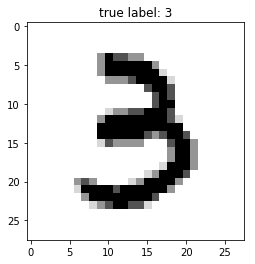

In [3]:
def plot_digit(X, y, idx):
    img = X[idx].reshape(28,28)
    plt.imshow(img, cmap='Greys',  interpolation='nearest')
    plt.title('true label: %d' % y[idx])
    plt.show()
    
plot_digit(X, y, 1)

In [4]:
import numpy as np
import sys

class NNClassifier:

    def __init__(self, n_classes, n_features, n_hidden_units=30,
                 l1=0.0, l2=0.0, epochs=500, learning_rate=0.01,
                 n_batches=1, random_seed=None):

        if random_seed:
            np.random.seed(random_seed)
        self.n_classes = n_classes
        self.n_features = n_features
        self.n_hidden_units = n_hidden_units
        self.w1, self.w2 = self._init_weights()
        self.l1 = l1
        self.l2 = l2
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.n_batches = n_batches

    def _init_weights(self):
        w1 = np.random.uniform(-1.0, 1.0, size=self.n_hidden_units * (self.n_features + 1))
        w1 = w1.reshape(self.n_hidden_units, self.n_features + 1)
        w2 = np.random.uniform(-1.0, 1.0, size=self.n_classes * (self.n_hidden_units + 1))
        w2 = w2.reshape(self.n_classes, self.n_hidden_units + 1)
        return w1, w2

    def _add_bias_unit(self, X, how='column'):
        """Add bias unit (column or row of 1s) to array at index 0"""
        if how == 'column':
            X_new = np.ones((X.shape[0], X.shape[1]+1))
            X_new[:, 1:] = X
        elif how == 'row':
            X_new = np.ones((X.shape[0]+1, X.shape[1]))
            X_new[1:, :] = X
        else:
            raise AttributeError('how must be columns or row')
        return X_new

    def _forward(self, X):
        a1 = self._add_bias_unit(X, how='column')
        z2 = self.w1.dot(a1.T)
        a2 = sigmoid(z2)
        a2 = self._add_bias_unit(a2, how='row')
        z3 = self.w2.dot(a2)
        a3 = sigmoid(z3)
        return a1, z2, a2, z3, a3
    
    def _backward(self, hidden_layer, input_activation, hidden_activation, output_activation, y):
        sigma3 = output_activation - y
        hidden_layer = self._add_bias_unit(hidden_layer, how='row')
        sigma2 = self.w2.T.dot(sigma3) * sigmoid_gradient(hidden_layer)
        sigma2 = sigma2[1:, :]
        grad1 = sigma2.dot(input_activation)
        grad2 = sigma3.dot(hidden_activation.T)
        return grad1, grad2

    def _get_cost(self, y, output):
        L1_term = L1_reg(self.l1, self.w1, self.w2)
        L2_term = L2_reg(self.l2, self.w1, self.w2)
        cost = cross_entropy(output, y) + L1_term + L2_term
        return 0.5 * np.mean(cost)

    def _get_gradient(self, X, y):
        a1, z2, a2, z3, a3 = self._forward(X)
        y = y.T
        cost = self._get_cost(y, a3)

        grad1, grad2 = self._backward(z2, a1, a2, a3, y)

        # regularize
        grad1[:, 1:] += (self.w1[:, 1:] * (self.l1 + self.l2))
        grad2[:, 1:] += (self.w2[:, 1:] * (self.l1 + self.l2))

        return cost, grad1, grad2

    def predict(self, X):
        Xt = X.copy()

        a1, z2, a2, z3, a3 = self._forward(Xt)
        return mle(z3.T)
    
    def predict_proba(self, X):
        a1, z2, a2, z3, a3 = self._forward(X)
        return softmax(a3.T)

    def fit(self, X, y):
        self.cost_ = []
        X_data, y_data = X.copy(), y.copy()
        y_data_enc = one_hot(y_data, self.n_classes)
        for i in range(self.epochs):

            X_mb = np.array_split(X_data, self.n_batches)
            y_mb = np.array_split(y_data_enc, self.n_batches)

            for Xi, yi in zip(X_mb, y_mb):
                
                # update weights
                cost, grad1, grad2 = self._get_gradient(Xi, yi)
                self.cost_.append(cost)
                self.w1 -= (self.learning_rate * grad1)
                self.w2 -= (self.learning_rate * grad2)

        return self
    
    def score(self, X, y):
        y_hat = self.predict(X)
        return np.sum(y == y_hat, axis=0) / float(X.shape[0])

In [5]:
nn = NNClassifier(n_classes=N_CLASSES, 
                  n_features=X_train.shape[1],
                  n_hidden_units=50,
                  l2=0.5,
                  l1=0.0,
                  epochs=300,
                  learning_rate=0.001,
                  n_batches=25,
                  random_seed=RANDOM_SEED)

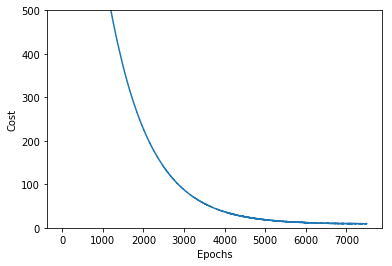

In [6]:
import matplotlib.pyplot as plt

nn.fit(X_train, y_train)

plt.plot(range(len(nn.cost_)), nn.cost_)
plt.ylim([0, 500])
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.show()

In [7]:
print('Train Accuracy: %.2f%%' % (nn.score(X_train, y_train) * 100))
print('Test Accuracy: %.2f%%' % (nn.score(X_test, y_test) * 100))

Train Accuracy: 91.80%
Test Accuracy: 81.65%


In [8]:
nn.predict_proba(X_test[:5])

array([[ 0.09035949,  0.15413943,  0.10413868,  0.09240382,  0.09270937,
         0.09134983,  0.09201285,  0.0901884 ,  0.10168506,  0.09101307],
       [ 0.09006643,  0.08982926,  0.09148965,  0.08801483,  0.08905539,
         0.09358783,  0.18462954,  0.08784268,  0.09758406,  0.08790033],
       [ 0.08764344,  0.18688476,  0.09135589,  0.09193231,  0.08872098,
         0.09138554,  0.08971505,  0.09022658,  0.08971823,  0.09241722],
       [ 0.18758876,  0.0868079 ,  0.09603454,  0.08975343,  0.08712031,
         0.09169447,  0.0897783 ,  0.08905143,  0.08835402,  0.09381683],
       [ 0.08859236,  0.08704482,  0.08557278,  0.08828382,  0.10025909,
         0.17975231,  0.0880831 ,  0.10175369,  0.08869118,  0.09196685]])

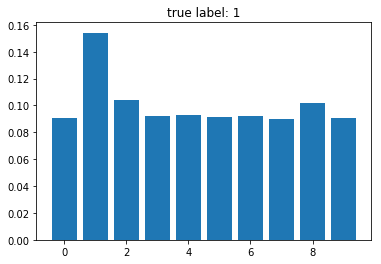

In [9]:
plt.bar(range(N_CLASSES), nn.predict_proba(X_test[:1])[0]);
plt.title('true label: %d' % y_test[:1]);

In [10]:
mle(nn.predict_proba(X_test[:5]))

array([1, 6, 1, 0, 5])

In [11]:
nn.predict(X_test[:5])

array([1, 6, 1, 0, 5])